In [77]:
# 量化表
# 亮度和色度量化表
QY1 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
               [12, 12, 14, 19, 26, 48, 60, 55],
               [14, 13, 16, 24, 40, 57, 69, 56],
               [14, 17, 22, 29, 51, 87, 80, 62],
               [18, 22, 37, 56, 68, 109, 103, 77],
               [24, 35, 55, 64, 81, 104, 113, 92],
               [49, 64, 78, 87, 103, 121, 120, 101],
               [72, 92, 95, 98, 112, 100, 103, 99]])
QC1 = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
               [18, 21, 26, 66, 99, 99, 99, 99],
               [24, 26, 56, 99, 99, 99, 99, 99],
               [47, 66, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99]])
Q1 = [QY1, QC1, QC1]

QY2 = QY1 * 5
QC2 = QC1 * 5
Q2 = [QY2, QC2, QC2]

QY3 = QY2 * 5
QC3 = QC2 * 5
Q3 = [QY3, QC3, QC3]

QY4 = (QY1 / 10).astype('uint')
QC4 = (QC1 / 10).astype('uint')
Q4 = [QY4, QC4, QC4]
img = imageio.imread('source.png')
# 块大小
B = 8
# 图片的大小，保证图片大小可以被8整除
height, width = (np.array(img.shape[:2]) // B * B).astype(np.int32)
img = img[:height, :width]
# 原始图片大小
origin_count = 0
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        for k in range(img.shape[2]):
            origin_count += bits_required(img[i][j][k])

实验1

In [79]:
import argparse
import os
import math
import numpy as np
from scipy import fftpack
from PIL import Image
from matplotlib import pyplot as plt
from skimage import img_as_ubyte
import cv2
from utility import *
from huffmantree import HuffmanTree
import imageio


if __name__ == "__main__":
    img = imageio.imread('source.png')
    # 块大小
    B = 8
    # 图片的大小，保证图片大小可以被8整除
    height, width = (np.array(img.shape[:2]) // B * B).astype(np.int32)
    img = img[:height, :width]
    # 把RGB转换成YCbCr颜色模型
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    # 显示YCbCr图片
    # plt.imshow(ycbcr)
    # plt.show()
    # 每两个像素垂直采样一次
    vertical_subsample = 2
    # 每两个像素水平采样一次
    horizontal_subsample = 2
    # print("ycbcr:",ycbcr.shape)
    
    # 2*2平滑滤波（取区域内的平均值）
    crf = cv2.boxFilter(ycbcr[:, :, 1], ddepth=-1, ksize=(2, 2))
    cbf = cv2.boxFilter(ycbcr[:, :, 2], ddepth=-1, ksize=(2, 2))
    # print("crf:",crf.shape)
    # print("cbf", cbf.shape)

    # 每隔一行和一列采样，即2*2区域内采样一次
    crsub = crf[::vertical_subsample, ::horizontal_subsample]
    cbsub = cbf[::vertical_subsample, ::horizontal_subsample]
    
    # print("crsub:", crsub.shape)
    # print("cbsub:", cbsub.shape)

    # 将三个通道下采样后的像素值存入列表
    sub_img = [ycbcr[:, :, 0], crsub, cbsub]

    # 所有dct变换后的块
    dct_blocks = []
    # 所有量化后的块
    quan_blocks = []
    # YCrCb颜色通道
    ch = ['Y', 'Cr', 'Cb']
    
    # 所有z扫描后的向量
    Zs = []
    # 遍历每个颜色通道
    for index, channel in enumerate(sub_img):
        # 行数
        rows = channel.shape[0]
        # 列数
        cols = channel.shape[1]
        # print(index, channel.shape)
        # print(rows)
        # print(cols)
        # dct变换后的块
        dct_block = np.zeros((rows, cols), np.int32)
        # 量化后的块
        quan_block = np.zeros((rows, cols), np.int32)
        # 块的行数
        block_rows = int(rows / B)
        # 块的列数
        block_cols = int(cols / B)
        # print("block-rows and block-cols", block_rows, block_cols)
        # z扫描后的向量
        z = []

        block = np.zeros((rows, cols), np.float32)
        block[:rows, :cols] = channel
        # 整齐化，减128使Y分量（DC）成为均值为0。
        block = block - 128
        # 处理每个块
        for row in range(block_rows):
            for col in range(block_cols):
                # 当前块
                currentblock = fftpack.dct(
                    fftpack.dct(block[row * B:(row + 1) * B, col * B:(col + 1) * B].T, norm='ortho').T,
                    norm='ortho').round().astype(np.int32)
                # 存储二维dct变换后的块
                dct_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = currentblock
                # 存储量化后的块
                quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = np.round(currentblock / Q1[index])
                # z扫描
                z.append(block_to_zigzag(quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B]))

        dct_blocks.append(dct_block)
        quan_blocks.append(quan_block)
        Zs.append(z)

    dcs = dcpm(Zs)
    # print("dcs1:", len(dcs[1]))
    dcs_values = dc(Zs)
    # acs_symbol1存的是run_length_encode以后的值
    acs_symbol1 = rlc(Zs)
    # acs存的是未编码的ac值
    acs = ac(Zs)
    # acs_bin存的是ac值的二进制串
    acs_bin = rlc_values(Zs)
    # print(len(dcs1[0]))
    H_DC_Y = HuffmanTree(dcs[0])
    H_DC_C = HuffmanTree(dcs[1] + dcs[2])
    H_AC_Y = HuffmanTree(flatten(acs_symbol1[0]))
    H_AC_C = HuffmanTree(flatten(acs_symbol1[1]) + flatten(acs_symbol1[2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    count = write_to_file('encode.b', dcs, dcs_values, acs_symbol1, acs_bin, tables)
    print("图片写入位数：\n", count)
    print("图片压缩比：\n", count / origin_count)


图片写入位数：
 560856
图片压缩比：
 0.034996462328241655


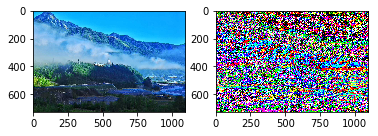

In [80]:
# 要求：1. 查阅资料，了解JPEG图片压缩流程，依照encode.py实现的压缩代码，编写相应的decode代码。
#      2. 调整量化表，观察不同量化表压缩后的解压图像差异，至少做4组，图像要有差异，outimg是当前量化表压缩后解压得到的图片
#      3. 实验报告记录解压后的图、压缩率和重构误差图像
#      4. 实验报告和代码打包提交到ftp，截至时间是5/13 
    
if __name__ == "__main__":
    # step 1
    # 读取二进制文件并进行hafuman解码，还原成Z型数组
    # des是直流系数，acs是交流系数，Y_blocks_count是Y的块数，C_blocks_count是Cr和Cb的块数，tables可以不适用    
    dcs, acs, Y_blocks_count, C_blocks_count, tables = read_image_file('encode.b')
    for i in range(len(dcs)):
        for j in range(len(dcs[i])):
            if j == 0:
                continue
            dcs[i][j] += dcs[i][j-1]
    Zs = []
    for i in range(len(dcs)):
        z = []
        for j in range(len(dcs[i])):
            z.append([dcs[i][j]] + acs[i][j])
        Zs.append(z)
    
    # step 2
    # 将Z型数组还原成 8 X 8 的块
    # 注意：dc系数解码后仍然是dcpm，需要转换成原有形式
    # 对每一块都进行逆量化和逆DCT变换
    
    def zigzag_to_block(zigzag):
        block = np.zeros((8,8))
        point = zigzag_points(8,8)
        track = [a for a in point]
        pos = 0
        for index, value in enumerate(track):
            block[value[0]][value[1]] = zigzag[index]
        return block
    
    blocks = []
    for i in range(len(Zs)):
        if i == 0:
            block = np.zeros((728, 1096))
            raws_number = 91
            cols_number = 137
        else:
            block = np.zeros((360, 544))
            raws_number = 45
            cols_number = 68
        for raw in range(raws_number):
            for col in range(cols_number):
                currentblock = zigzag_to_block(Zs[i][raw*cols_number+col])
                currentblock *= Q1[i]
                currentblock = fftpack.idct(fftpack.idct(currentblock.T, norm='ortho').T, norm='ortho').round().astype(np.int32)
                block[raw*8:(raw+1)*8, col*8:(col+1)*8] = currentblock
        blocks.append(block+128)
    
    Y = np.zeros((728, 1096))
    Y[:,:] = blocks[0]
    Cr = cv2.resize(blocks[1],(1096, 728))
    Cb = cv2.resize(blocks[2],(1096, 728))
    myimg = cv2.merge([Y, Cr, Cb])
    a = cv2.cvtColor(myimg.astype('uint8'), cv2.COLOR_YCrCb2RGB)
    plt.subplot(121)
    plt.imshow(a)
    plt.subplot(122)
    plt.imshow(img-a)

实验2

In [81]:
if __name__ == "__main__":
    img = imageio.imread('source.png')
    # 块大小
    B = 8
    # 图片的大小，保证图片大小可以被8整除
    height, width = (np.array(img.shape[:2]) // B * B).astype(np.int32)
    img = img[:height, :width]
    # 把RGB转换成YCbCr颜色模型
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    # 显示YCbCr图片
    # plt.imshow(ycbcr)
    # plt.show()
    # 每两个像素垂直采样一次
    vertical_subsample = 2
    # 每两个像素水平采样一次
    horizontal_subsample = 2
    # print("ycbcr:",ycbcr.shape)
    
    # 2*2平滑滤波（取区域内的平均值）
    crf = cv2.boxFilter(ycbcr[:, :, 1], ddepth=-1, ksize=(2, 2))
    cbf = cv2.boxFilter(ycbcr[:, :, 2], ddepth=-1, ksize=(2, 2))
    # print("crf:",crf.shape)
    # print("cbf", cbf.shape)

    # 每隔一行和一列采样，即2*2区域内采样一次
    crsub = crf[::vertical_subsample, ::horizontal_subsample]
    cbsub = cbf[::vertical_subsample, ::horizontal_subsample]
    
    # print("crsub:", crsub.shape)
    # print("cbsub:", cbsub.shape)

    # 将三个通道下采样后的像素值存入列表
    sub_img = [ycbcr[:, :, 0], crsub, cbsub]

    # 所有dct变换后的块
    dct_blocks = []
    # 所有量化后的块
    quan_blocks = []
    # YCrCb颜色通道
    ch = ['Y', 'Cr', 'Cb']
    
    # 所有z扫描后的向量
    Zs = []
    # 遍历每个颜色通道
    for index, channel in enumerate(sub_img):
        # 行数
        rows = channel.shape[0]
        # 列数
        cols = channel.shape[1]
        # print(index, channel.shape)
        # print(rows)
        # print(cols)
        # dct变换后的块
        dct_block = np.zeros((rows, cols), np.int32)
        # 量化后的块
        quan_block = np.zeros((rows, cols), np.int32)
        # 块的行数
        block_rows = int(rows / B)
        # 块的列数
        block_cols = int(cols / B)
        # print("block-rows and block-cols", block_rows, block_cols)
        # z扫描后的向量
        z = []

        block = np.zeros((rows, cols), np.float32)
        block[:rows, :cols] = channel
        # 整齐化，减128使Y分量（DC）成为均值为0。
        block = block - 128
        # 处理每个块
        for row in range(block_rows):
            for col in range(block_cols):
                # 当前块
                currentblock = fftpack.dct(
                    fftpack.dct(block[row * B:(row + 1) * B, col * B:(col + 1) * B].T, norm='ortho').T,
                    norm='ortho').round().astype(np.int32)
                # 存储二维dct变换后的块
                dct_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = currentblock
                # 存储量化后的块
                quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = np.round(currentblock / Q2[index])
                # z扫描
                z.append(block_to_zigzag(quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B]))

        dct_blocks.append(dct_block)
        quan_blocks.append(quan_block)
        Zs.append(z)

    dcs = dcpm(Zs)
    # print("dcs1:", len(dcs[1]))
    dcs_values = dc(Zs)
    # acs_symbol1存的是run_length_encode以后的值
    acs_symbol1 = rlc(Zs)
    # acs存的是未编码的ac值
    acs = ac(Zs)
    # acs_bin存的是ac值的二进制串
    acs_bin = rlc_values(Zs)
    # print(len(dcs1[0]))
    H_DC_Y = HuffmanTree(dcs[0])
    H_DC_C = HuffmanTree(dcs[1] + dcs[2])
    H_AC_Y = HuffmanTree(flatten(acs_symbol1[0]))
    H_AC_C = HuffmanTree(flatten(acs_symbol1[1]) + flatten(acs_symbol1[2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    count = write_to_file('encode.b', dcs, dcs_values, acs_symbol1, acs_bin, tables)
    print("图片写入位数：\n", count)
    print("图片压缩比：\n", count / origin_count)


图片写入位数：
 137483
图片压缩比：
 0.008578705818023962


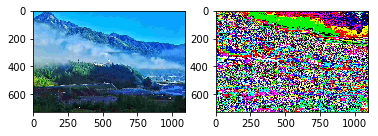

In [58]:


# 要求：1. 查阅资料，了解JPEG图片压缩流程，依照encode.py实现的压缩代码，编写相应的decode代码。
#      2. 调整量化表，观察不同量化表压缩后的解压图像差异，至少做4组，图像要有差异，outimg是当前量化表压缩后解压得到的图片
#      3. 实验报告记录解压后的图、压缩率和重构误差图像
#      4. 实验报告和代码打包提交到ftp，截至时间是5/13 
    
if __name__ == "__main__":
    # step 1
    # 读取二进制文件并进行hafuman解码，还原成Z型数组
    # des是直流系数，acs是交流系数，Y_blocks_count是Y的块数，C_blocks_count是Cr和Cb的块数，tables可以不适用    
    dcs, acs, Y_blocks_count, C_blocks_count, tables = read_image_file('encode.b')
    for i in range(len(dcs)):
        for j in range(len(dcs[i])):
            if j == 0:
                continue
            dcs[i][j] += dcs[i][j-1]
    Zs = []
    for i in range(len(dcs)):
        z = []
        for j in range(len(dcs[i])):
            z.append([dcs[i][j]] + acs[i][j])
        Zs.append(z)
    
    # step 2
    # 将Z型数组还原成 8 X 8 的块
    # 注意：dc系数解码后仍然是dcpm，需要转换成原有形式
    # 对每一块都进行逆量化和逆DCT变换
    
    def zigzag_to_block(zigzag):
        block = np.zeros((8,8))
        point = zigzag_points(8,8)
        track = [a for a in point]
        pos = 0
        for index, value in enumerate(track):
            block[value[0]][value[1]] = zigzag[index]
        return block
    
    blocks = []
    for i in range(len(Zs)):
        if i == 0:
            block = np.zeros((728, 1096))
            raws_number = 91
            cols_number = 137
        else:
            block = np.zeros((360, 544))
            raws_number = 45
            cols_number = 68
        for raw in range(raws_number):
            for col in range(cols_number):
                currentblock = zigzag_to_block(Zs[i][raw*cols_number+col])
                currentblock *= Q2[i]
                currentblock = fftpack.idct(fftpack.idct(currentblock.T, norm='ortho').T, norm='ortho').round().astype(np.int32)
                block[raw*8:(raw+1)*8, col*8:(col+1)*8] = currentblock
        blocks.append(block+128)
    
    Y = np.zeros((728, 1096))
    Y[:,:] = blocks[0]
    Cr = cv2.resize(blocks[1],(1096, 728))
    Cb = cv2.resize(blocks[2],(1096, 728))
    myimg = cv2.merge([Y, Cr, Cb])
    a = cv2.cvtColor(myimg.astype('uint8'), cv2.COLOR_YCrCb2RGB)
    plt.subplot(121)
    plt.imshow(a)
    plt.subplot(122)
    plt.imshow(img-a)

实验3

In [82]:
if __name__ == "__main__":
    img = imageio.imread('source.png')
    # 块大小
    B = 8
    # 图片的大小，保证图片大小可以被8整除
    height, width = (np.array(img.shape[:2]) // B * B).astype(np.int32)
    img = img[:height, :width]
    # 把RGB转换成YCbCr颜色模型
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    # 显示YCbCr图片
    # plt.imshow(ycbcr)
    # plt.show()
    # 每两个像素垂直采样一次
    vertical_subsample = 2
    # 每两个像素水平采样一次
    horizontal_subsample = 2
    # print("ycbcr:",ycbcr.shape)
    
    # 2*2平滑滤波（取区域内的平均值）
    crf = cv2.boxFilter(ycbcr[:, :, 1], ddepth=-1, ksize=(2, 2))
    cbf = cv2.boxFilter(ycbcr[:, :, 2], ddepth=-1, ksize=(2, 2))
    # print("crf:",crf.shape)
    # print("cbf", cbf.shape)

    # 每隔一行和一列采样，即2*2区域内采样一次
    crsub = crf[::vertical_subsample, ::horizontal_subsample]
    cbsub = cbf[::vertical_subsample, ::horizontal_subsample]
    
    # print("crsub:", crsub.shape)
    # print("cbsub:", cbsub.shape)

    # 将三个通道下采样后的像素值存入列表
    sub_img = [ycbcr[:, :, 0], crsub, cbsub]

    # 所有dct变换后的块
    dct_blocks = []
    # 所有量化后的块
    quan_blocks = []
    # YCrCb颜色通道
    ch = ['Y', 'Cr', 'Cb']
    
    # 所有z扫描后的向量
    Zs = []
    # 遍历每个颜色通道
    for index, channel in enumerate(sub_img):
        # 行数
        rows = channel.shape[0]
        # 列数
        cols = channel.shape[1]
        # print(index, channel.shape)
        # print(rows)
        # print(cols)
        # dct变换后的块
        dct_block = np.zeros((rows, cols), np.int32)
        # 量化后的块
        quan_block = np.zeros((rows, cols), np.int32)
        # 块的行数
        block_rows = int(rows / B)
        # 块的列数
        block_cols = int(cols / B)
        # print("block-rows and block-cols", block_rows, block_cols)
        # z扫描后的向量
        z = []

        block = np.zeros((rows, cols), np.float32)
        block[:rows, :cols] = channel
        # 整齐化，减128使Y分量（DC）成为均值为0。
        block = block - 128
        # 处理每个块
        for row in range(block_rows):
            for col in range(block_cols):
                # 当前块
                currentblock = fftpack.dct(
                    fftpack.dct(block[row * B:(row + 1) * B, col * B:(col + 1) * B].T, norm='ortho').T,
                    norm='ortho').round().astype(np.int32)
                # 存储二维dct变换后的块
                dct_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = currentblock
                # 存储量化后的块
                quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = np.round(currentblock / Q3[index])
                # z扫描
                z.append(block_to_zigzag(quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B]))

        dct_blocks.append(dct_block)
        quan_blocks.append(quan_block)
        Zs.append(z)

    dcs = dcpm(Zs)
    # print("dcs1:", len(dcs[1]))
    dcs_values = dc(Zs)
    # acs_symbol1存的是run_length_encode以后的值
    acs_symbol1 = rlc(Zs)
    # acs存的是未编码的ac值
    acs = ac(Zs)
    # acs_bin存的是ac值的二进制串
    acs_bin = rlc_values(Zs)
    # print(len(dcs1[0]))
    H_DC_Y = HuffmanTree(dcs[0])
    H_DC_C = HuffmanTree(dcs[1] + dcs[2])
    H_AC_Y = HuffmanTree(flatten(acs_symbol1[0]))
    H_AC_C = HuffmanTree(flatten(acs_symbol1[1]) + flatten(acs_symbol1[2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    count = write_to_file('encode.b', dcs, dcs_values, acs_symbol1, acs_bin, tables)
    print("图片写入位数：\n", count)
    print("图片压缩比：\n", count / origin_count)


图片写入位数：
 38186
图片压缩比：
 0.002382741577991919


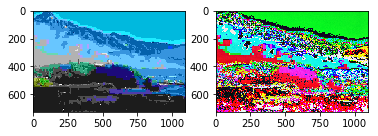

In [60]:


# 要求：1. 查阅资料，了解JPEG图片压缩流程，依照encode.py实现的压缩代码，编写相应的decode代码。
#      2. 调整量化表，观察不同量化表压缩后的解压图像差异，至少做4组，图像要有差异，outimg是当前量化表压缩后解压得到的图片
#      3. 实验报告记录解压后的图、压缩率和重构误差图像
#      4. 实验报告和代码打包提交到ftp，截至时间是5/13 
    
if __name__ == "__main__":
    # step 1
    # 读取二进制文件并进行hafuman解码，还原成Z型数组
    # des是直流系数，acs是交流系数，Y_blocks_count是Y的块数，C_blocks_count是Cr和Cb的块数，tables可以不适用    
    dcs, acs, Y_blocks_count, C_blocks_count, tables = read_image_file('encode.b')
    for i in range(len(dcs)):
        for j in range(len(dcs[i])):
            if j == 0:
                continue
            dcs[i][j] += dcs[i][j-1]
    Zs = []
    for i in range(len(dcs)):
        z = []
        for j in range(len(dcs[i])):
            z.append([dcs[i][j]] + acs[i][j])
        Zs.append(z)
    
    # step 2
    # 将Z型数组还原成 8 X 8 的块
    # 注意：dc系数解码后仍然是dcpm，需要转换成原有形式
    # 对每一块都进行逆量化和逆DCT变换
    
    def zigzag_to_block(zigzag):
        block = np.zeros((8,8))
        point = zigzag_points(8,8)
        track = [a for a in point]
        pos = 0
        for index, value in enumerate(track):
            block[value[0]][value[1]] = zigzag[index]
        return block
    
    blocks = []
    for i in range(len(Zs)):
        if i == 0:
            block = np.zeros((728, 1096))
            raws_number = 91
            cols_number = 137
        else:
            block = np.zeros((360, 544))
            raws_number = 45
            cols_number = 68
        for raw in range(raws_number):
            for col in range(cols_number):
                currentblock = zigzag_to_block(Zs[i][raw*cols_number+col])
                currentblock *= Q3[i]
                currentblock = fftpack.idct(fftpack.idct(currentblock.T, norm='ortho').T, norm='ortho').round().astype(np.int32)
                block[raw*8:(raw+1)*8, col*8:(col+1)*8] = currentblock
        blocks.append(block+128)
    
    Y = np.zeros((728, 1096))
    Y[:,:] = blocks[0]
    Cr = cv2.resize(blocks[1],(1096, 728))
    Cb = cv2.resize(blocks[2],(1096, 728))
    myimg = cv2.merge([Y, Cr, Cb])
    a = cv2.cvtColor(myimg.astype('uint8'), cv2.COLOR_YCrCb2RGB)
    plt.subplot(121)
    plt.imshow(a)
    plt.subplot(122)
    plt.imshow(img-a)

实验4

In [83]:
if __name__ == "__main__":
    img = imageio.imread('source.png')
    # 块大小
    B = 8
    # 图片的大小，保证图片大小可以被8整除
    height, width = (np.array(img.shape[:2]) // B * B).astype(np.int32)
    img = img[:height, :width]
    # 把RGB转换成YCbCr颜色模型
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    # 显示YCbCr图片
    # plt.imshow(ycbcr)
    # plt.show()
    # 每两个像素垂直采样一次
    vertical_subsample = 2
    # 每两个像素水平采样一次
    horizontal_subsample = 2
    # print("ycbcr:",ycbcr.shape)
    
    # 2*2平滑滤波（取区域内的平均值）
    crf = cv2.boxFilter(ycbcr[:, :, 1], ddepth=-1, ksize=(2, 2))
    cbf = cv2.boxFilter(ycbcr[:, :, 2], ddepth=-1, ksize=(2, 2))
    # print("crf:",crf.shape)
    # print("cbf", cbf.shape)

    # 每隔一行和一列采样，即2*2区域内采样一次
    crsub = crf[::vertical_subsample, ::horizontal_subsample]
    cbsub = cbf[::vertical_subsample, ::horizontal_subsample]
    
    # print("crsub:", crsub.shape)
    # print("cbsub:", cbsub.shape)

    # 将三个通道下采样后的像素值存入列表
    sub_img = [ycbcr[:, :, 0], crsub, cbsub]

    # 所有dct变换后的块
    dct_blocks = []
    # 所有量化后的块
    quan_blocks = []
    # YCrCb颜色通道
    ch = ['Y', 'Cr', 'Cb']
    
    # 所有z扫描后的向量
    Zs = []
    # 遍历每个颜色通道
    for index, channel in enumerate(sub_img):
        # 行数
        rows = channel.shape[0]
        # 列数
        cols = channel.shape[1]
        # print(index, channel.shape)
        # print(rows)
        # print(cols)
        # dct变换后的块
        dct_block = np.zeros((rows, cols), np.int32)
        # 量化后的块
        quan_block = np.zeros((rows, cols), np.int32)
        # 块的行数
        block_rows = int(rows / B)
        # 块的列数
        block_cols = int(cols / B)
        # print("block-rows and block-cols", block_rows, block_cols)
        # z扫描后的向量
        z = []

        block = np.zeros((rows, cols), np.float32)
        block[:rows, :cols] = channel
        # 整齐化，减128使Y分量（DC）成为均值为0。
        block = block - 128
        # 处理每个块
        for row in range(block_rows):
            for col in range(block_cols):
                # 当前块
                currentblock = fftpack.dct(
                    fftpack.dct(block[row * B:(row + 1) * B, col * B:(col + 1) * B].T, norm='ortho').T,
                    norm='ortho').round().astype(np.int32)
                # 存储二维dct变换后的块
                dct_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = currentblock
                # 存储量化后的块
                quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B] = np.round(currentblock / Q4[index])
                # z扫描
                z.append(block_to_zigzag(quan_block[row * B:(row + 1) * B, col * B:(col + 1) * B]))

        dct_blocks.append(dct_block)
        quan_blocks.append(quan_block)
        Zs.append(z)

    dcs = dcpm(Zs)
    # print("dcs1:", len(dcs[1]))
    dcs_values = dc(Zs)
    # acs_symbol1存的是run_length_encode以后的值
    acs_symbol1 = rlc(Zs)
    # acs存的是未编码的ac值
    acs = ac(Zs)
    # acs_bin存的是ac值的二进制串
    acs_bin = rlc_values(Zs)
    # print(len(dcs1[0]))
    H_DC_Y = HuffmanTree(dcs[0])
    H_DC_C = HuffmanTree(dcs[1] + dcs[2])
    H_AC_Y = HuffmanTree(flatten(acs_symbol1[0]))
    H_AC_C = HuffmanTree(flatten(acs_symbol1[1]) + flatten(acs_symbol1[2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    count = write_to_file('encode.b', dcs, dcs_values, acs_symbol1, acs_bin, tables)
    print("图片写入位数：\n", count)
    print("图片压缩比：\n", count / origin_count)

图片写入位数：
 2802376
图片压缩比：
 0.17486350527331174


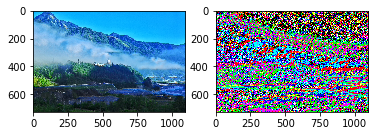

In [62]:


# 要求：1. 查阅资料，了解JPEG图片压缩流程，依照encode.py实现的压缩代码，编写相应的decode代码。
#      2. 调整量化表，观察不同量化表压缩后的解压图像差异，至少做4组，图像要有差异，outimg是当前量化表压缩后解压得到的图片
#      3. 实验报告记录解压后的图、压缩率和重构误差图像
#      4. 实验报告和代码打包提交到ftp，截至时间是5/13 
    
if __name__ == "__main__":
    # step 1
    # 读取二进制文件并进行hafuman解码，还原成Z型数组
    # des是直流系数，acs是交流系数，Y_blocks_count是Y的块数，C_blocks_count是Cr和Cb的块数，tables可以不适用    
    dcs, acs, Y_blocks_count, C_blocks_count, tables = read_image_file('encode.b')
    for i in range(len(dcs)):
        for j in range(len(dcs[i])):
            if j == 0:
                continue
            dcs[i][j] += dcs[i][j-1]
    Zs = []
    for i in range(len(dcs)):
        z = []
        for j in range(len(dcs[i])):
            z.append([dcs[i][j]] + acs[i][j])
        Zs.append(z)
    
    # step 2
    # 将Z型数组还原成 8 X 8 的块
    # 注意：dc系数解码后仍然是dcpm，需要转换成原有形式
    # 对每一块都进行逆量化和逆DCT变换
    
    def zigzag_to_block(zigzag):
        block = np.zeros((8,8))
        point = zigzag_points(8,8)
        track = [a for a in point]
        pos = 0
        for index, value in enumerate(track):
            block[value[0]][value[1]] = zigzag[index]
        return block
    
    blocks = []
    for i in range(len(Zs)):
        if i == 0:
            block = np.zeros((728, 1096))
            raws_number = 91
            cols_number = 137
        else:
            block = np.zeros((360, 544))
            raws_number = 45
            cols_number = 68
        for raw in range(raws_number):
            for col in range(cols_number):
                currentblock = zigzag_to_block(Zs[i][raw*cols_number+col])
                currentblock *= Q4[i]
                currentblock = fftpack.idct(fftpack.idct(currentblock.T, norm='ortho').T, norm='ortho').round().astype(np.int32)
                block[raw*8:(raw+1)*8, col*8:(col+1)*8] = currentblock
        blocks.append(block+128)
    
    Y = np.zeros((728, 1096))
    Y[:,:] = blocks[0]
    Cr = cv2.resize(blocks[1],(1096, 728))
    Cb = cv2.resize(blocks[2],(1096, 728))
    myimg = cv2.merge([Y, Cr, Cb])
    a = cv2.cvtColor(myimg.astype('uint8'), cv2.COLOR_YCrCb2RGB)
    plt.subplot(121)
    plt.imshow(a)
    plt.subplot(122)
    plt.imshow(img-a)